# Use [markdown](https://www.markdownguide.org/basic-syntax/) to label each (sub)question neatly.

This notebook serves as your report. All your answers should be presented within it. 

You can submit multiple notebooks (e.g. 1 notebook per part / question).

Before submission, remember to tidy up the notebook and retain only relevant parts.

In [1]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import shap
shap.initjs()


import IPython.display as ipd

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix


import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler


c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
SEED = 42
import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

# Read Data

In [4]:
df = pd.read_csv('./full.csv') 
df.head()

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,app_3001_4001_phnd_neg_0000.wav,184.570312,623,69.222222,0.515281,0.093347,0.443441,0.082742,0.249143,0.021261,...,-10.669799,63.340282,1.811605,58.117188,-3.286546,54.268448,-2.719069,59.548176,-4.559987,70.774803
1,app_3001_4001_phnd_neg_0001.wav,151.999081,521,74.428571,0.487201,0.094461,0.542182,0.073359,0.274423,0.008025,...,-5.666375,90.256195,1.573594,105.070496,-0.742024,82.417496,-1.961745,119.312355,1.513660,101.014572
2,app_3001_4001_phnd_neg_0002.wav,112.347147,1614,146.727273,0.444244,0.099268,0.442014,0.083224,0.264430,0.013410,...,-5.502390,73.079750,0.202623,72.040550,-4.021009,73.844353,-5.916223,103.834824,-2.939086,113.598824
3,app_3001_4001_phnd_neg_0003.wav,107.666016,2060,158.461538,0.454156,0.100834,0.424370,0.084435,0.257672,0.016938,...,-8.812989,93.791893,-0.429413,60.002579,-4.013513,82.544540,-5.858006,84.402092,0.686969,90.126389
4,app_3001_4001_phnd_neg_0004.wav,75.999540,66,33.000000,0.478780,0.100000,0.414859,0.089313,0.252143,0.019757,...,-6.584204,64.973305,0.744403,68.908516,-6.354805,66.414391,-6.555534,47.852840,-4.809713,73.033966


In [5]:
df['label'] = df['filename'].str.split('_').str[-2]

In [6]:
df['label'].value_counts()

pos    92826
neg    89428
Name: label, dtype: int64

Split and scale dataset

In [7]:

columns_to_drop = ['label','filename']

def split_dataset(df, columns_to_drop, test_size, random_state):
  label_encoder = preprocessing.LabelEncoder()

  df['label'] = label_encoder.fit_transform(df['label'])

  df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)

  df_train2 = df_train.drop(columns_to_drop,axis=1)
  y_train2 = df_train['label'].to_numpy()

  df_test2 = df_test.drop(columns_to_drop,axis=1)
  y_test2 = df_test['label'].to_numpy() 

  return df_train2, y_train2, df_test2, y_test2

def preprocess_dataset(df_train, df_test):

  standard_scaler = preprocessing.StandardScaler()
  df_train_scaled = standard_scaler.fit_transform(df_train)

  df_test_scaled = standard_scaler.transform(df_test)

  return df_train_scaled, df_test_scaled

X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size=0.3, random_state=0) # positive labels being encoded as 1

X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

In [8]:
features = []
for i in X_train.columns[0:]:
    features.append(i)

## Question 1A

In [9]:
num_neurons = 128
learning_rate = 0.001
batch_size = 256
no_epochs = 100

In [10]:
model = Sequential([Dense(num_neurons, activation='relu'),
                    Dropout(0.2), Dense(num_neurons, activation ='relu'),
                    Dropout(0.2), Dense(num_neurons, activation='relu'),
                    Dropout(0.2), Dense(1, activation='sigmoid')])


In [11]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
model.compile(loss= 'binary_crossentropy', optimizer = "adam", metrics= ['accuracy']) # Default learning rate for adam algo is 0.001

In [12]:
history = {}
history['model'] = model.fit(X_train_scaled, y_train,
                            epochs = no_epochs, verbose = 1,
                            batch_size = batch_size, validation_data = (X_test_scaled, y_test), callbacks = [callback])

Epoch 1/100
499/499 [==============================] - 2s 3ms/step - loss: 0.6897 - accuracy: 0.5361 - val_loss: 0.6844 - val_accuracy: 0.5547
Epoch 2/100
499/499 [==============================] - 2s 3ms/step - loss: 0.6833 - accuracy: 0.5533 - val_loss: 0.6809 - val_accuracy: 0.5589
Epoch 3/100
499/499 [==============================] - 2s 3ms/step - loss: 0.6800 - accuracy: 0.5591 - val_loss: 0.6800 - val_accuracy: 0.5629
Epoch 4/100
499/499 [==============================] - 1s 3ms/step - loss: 0.6774 - accuracy: 0.5658 - val_loss: 0.6767 - val_accuracy: 0.5665
Epoch 5/100
499/499 [==============================] - 2s 4ms/step - loss: 0.6739 - accuracy: 0.5741 - val_loss: 0.6731 - val_accuracy: 0.5737
Epoch 6/100
499/499 [==============================] - 2s 4ms/step - loss: 0.6705 - accuracy: 0.5788 - val_loss: 0.6711 - val_accuracy: 0.5792
Epoch 7/100
499/499 [==============================] - 2s 4ms/step - loss: 0.6672 - accuracy: 0.5851 - val_loss: 0.6680 - val_accuracy: 0.5884

#### Plot of train and test accuracies training epochs

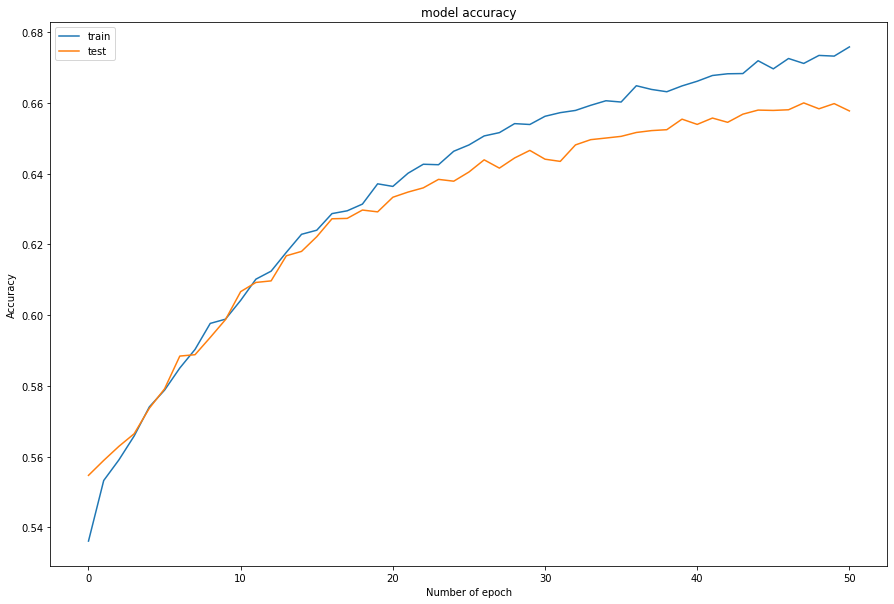

In [13]:
plt_1 = plt.figure(figsize=(15, 10))
plt.plot(history['model'].history['accuracy'])
plt.plot(history['model'].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Plot of train and test loss training epochs

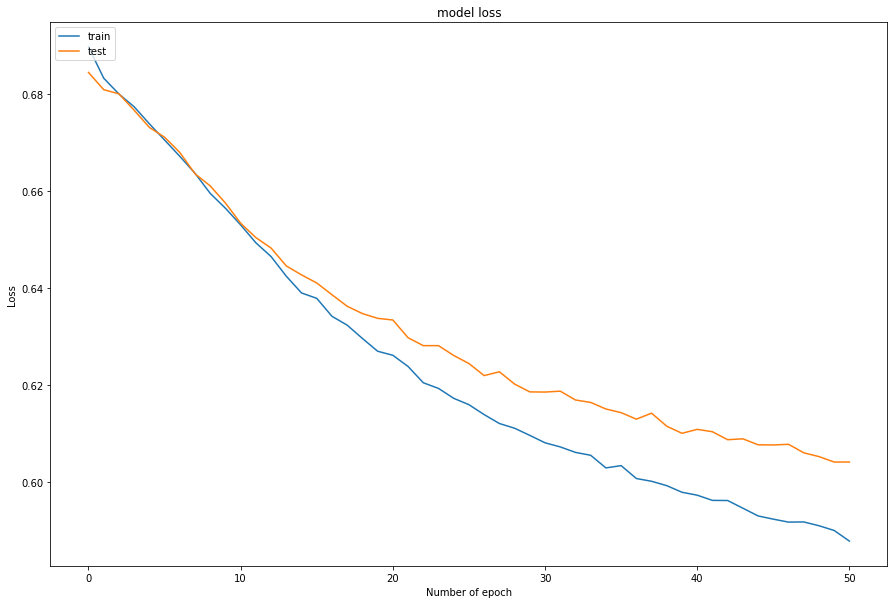

In [14]:
plt_1 = plt.figure(figsize=(15, 10))
plt.plot(history['model'].history['loss'])
plt.plot(history['model'].history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Number of epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Question 1B

#### Comments on the line plots

**Both training and validation accuracies of the model is increasing at a decreasing rate. Initially as the model trains, accuracy of the model rises sharply and its growth would decrease and eventually reach a plateau, if there was no early-stopping mechanism, the model might overfit which would compromise on the model's accuracy.**

**Both training and validation loss are decreasing until reaches the minimum. Loss indicates the error or "how bad" the predictions are against the targeted value. We used binary cross entropy as it compares each of the predicated probabilities to the actual class output which can be either 0 or 1. As such, we aim to minimize loss as it indicates robustness of the model.**



#### Why early stopping is required?

**Early stopping is required to reduce overfitting without compromising on model accuracy. With the early stopping technique, the model will stop training before it starts to overfit which leads to increase in error and a drop in model's accuracy. With patience of 3, the training would be stopped when validation accuracy do not improve after 3 epoch** 


## Question 2

In [15]:
from sklearn import datasets
from sklearn.model_selection import KFold

**Timing callback for every epoch**

In [16]:
# TimingCallBack class for Q2b

class TimingCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)



**Number of folds and batch sizes**

In [17]:
no_folds = 5
batch_size_list = [128, 256, 512, 1024]
cv = KFold(n_splits=no_folds, shuffle=True, random_state=0)

In [18]:
Q2_X, Q2_Y = X_train_scaled, y_train

In [19]:
model_acc = {}
model_train_acc = {}
model_loss = {}
Q2_history = {}
time_taken_dict = {}
batch_idx = 0

model_list = ["model_128", "model_256", "model_512", "model_1024"]
model_fold = ["_0", "_1", "_2", "_3" ,"_4"]

for models in model_list:
    fold = 0
    train_acc = []
    val_acc = []
    val_loss = []
    time_taken_list = []
    for train_idx, test_idx in cv.split(Q2_X, Q2_Y):
        cb = TimingCallback()
        Q2_X_train, Q2_y_train  = Q2_X[train_idx], Q2_Y[train_idx]
        Q2_X_test, Q2_y_test = Q2_X[test_idx], Q2_Y[test_idx]
    
        
        Q2_model = Sequential([Dense(num_neurons, activation='relu'),
                        Dropout(0.2), Dense(num_neurons, activation ='relu'),
                        Dropout(0.2), Dense(num_neurons, activation='relu'),
                        Dropout(0.2), Dense(1, activation='sigmoid')])
        
        Q2_model.compile(optimizer='adam', 
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
        
        Q2_history[models + model_fold[fold]] = Q2_model.fit(Q2_X_train, Q2_y_train,
                        batch_size = batch_size_list[batch_idx],
                        epochs=no_epochs,
                        verbose=1,
                        use_multiprocessing=True,
                        validation_data=(Q2_X_test, Q2_y_test), callbacks=[callback, cb])
        
        #Time taken of final epoch for each fold 
        time_taken_list.append(cb.times[-1])
        #print("Time Taken for final epoch " + models + model_fold[fold] + " : {}".format(cb.times[-1]))

        #Validation Accuracy of final epoch of each fold
        val_acc.append(Q2_history[models + model_fold[fold]].history['val_accuracy'][-1])

        #Training Accuracy of final epoch of each fold
        train_acc.append(Q2_history[models + model_fold[fold]].history['accuracy'][-1])
        
        #Val loss of final epoch of each fold
        val_loss.append(Q2_history[models + model_fold[fold]].history['val_loss'][-1])

        #print(models +' fold %d test accuracy %g'%(fold, val_acc[fold]))
        fold += 1
    
    batch_idx +=1
    model_acc[models] = val_acc
    model_train_acc[models] = train_acc
    model_loss[models] = val_loss
    time_taken_dict[models]= time_taken_list
    #print(models + '* mean accuracy = %g *'% np.mean(val_acc))
    


Epoch 1/100
798/798 [==============================] - 4s 4ms/step - loss: 0.6904 - accuracy: 0.5363 - val_loss: 0.6835 - val_accuracy: 0.5488
Epoch 2/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6837 - accuracy: 0.5493 - val_loss: 0.6817 - val_accuracy: 0.5576
Epoch 3/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6807 - accuracy: 0.5593 - val_loss: 0.6788 - val_accuracy: 0.5654
Epoch 4/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6780 - accuracy: 0.5651 - val_loss: 0.6764 - val_accuracy: 0.5693
Epoch 5/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6746 - accuracy: 0.5696 - val_loss: 0.6752 - val_accuracy: 0.5708
Epoch 6/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6721 - accuracy: 0.5742 - val_loss: 0.6720 - val_accuracy: 0.5766
Epoch 7/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6681 - accuracy: 0.5808 - val_loss: 0.6703 - val_accuracy: 0.5794

## Question 2A

#### Scatter plot of Mean Cross-validation accuracies against different batch_sizes**

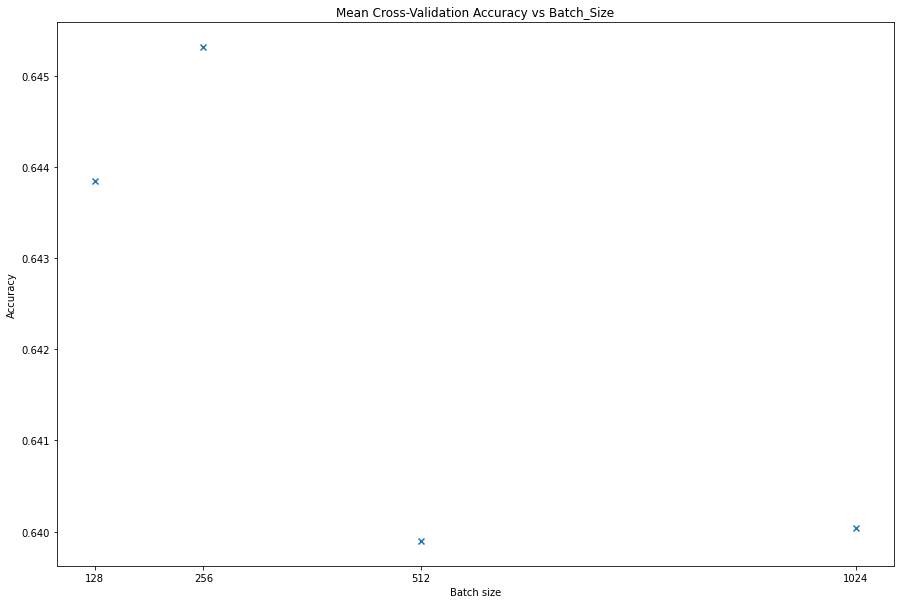

In [20]:
mean_val_acc = []
for key, value in model_acc.items():
    mean_val_acc.append(np.mean(value))

mean_val_loss = []
for key, value in model_loss.items():
    mean_val_loss.append(np.mean(value))

plt_1 = plt.figure(figsize=(15, 10))
plt.scatter(batch_size_list, mean_val_acc, marker = 'x')
plt.title('Mean Cross-Validation Accuracy vs Batch_Size')
plt.ylabel('Accuracy')
plt.xlabel('Batch size')
plt.xticks(batch_size_list)
plt.show()



## Question 2B


In [21]:
mean_time_taken = []
for key, value in time_taken_dict.items():
    mean_time_taken.append(np.mean(value))

#### Scatter plot of mean time taken of final epoch against batch size

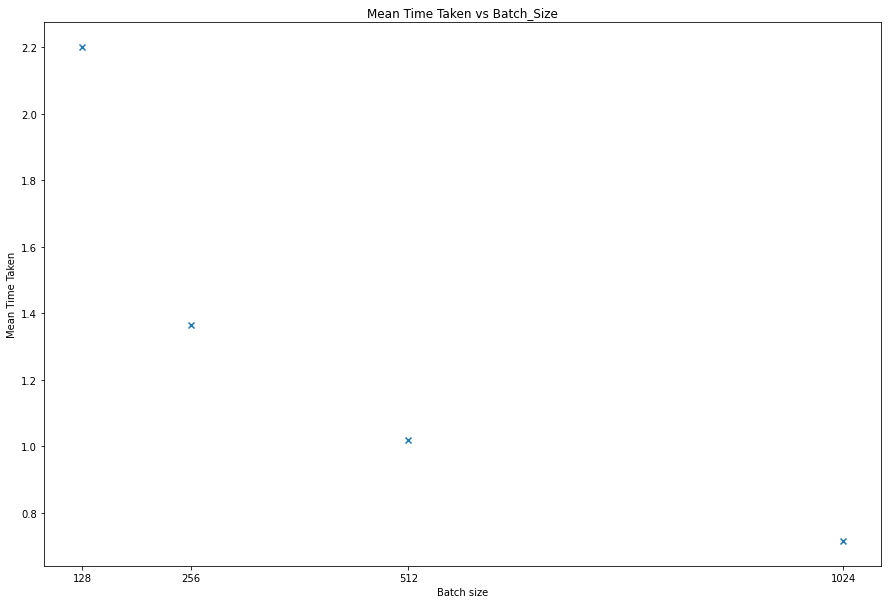

In [22]:
plt_1 = plt.figure(figsize=(15, 10))
plt.scatter(batch_size_list, mean_time_taken, marker = 'x')
plt.title('Mean Time Taken vs Batch_Size')
plt.ylabel('Mean Time Taken')
plt.xlabel('Batch size')
plt.xticks(batch_size_list)
plt.show()

#### Table of time taken to train the last epoch

In [23]:
table_df = pd.DataFrame.from_dict(model_acc,orient='index', columns=["fold_0", "fold_1", "fold_2", "fold_3", "fold_4"])
table_df["mean_val_acc"] = mean_val_acc
table_df["mean_val_loss"] = mean_val_loss
table_df["mean_time_taken"] = mean_time_taken
table_df["Batch model"] = model_list
table_df["Batch_size"] = batch_size_list
table_df.set_index('Batch_size', inplace = True)
table_df.head()

,fold_0,fold_1,fold_2,fold_3,fold_4,mean_val_acc,mean_val_loss,mean_time_taken,Batch model
Batch_size,,,,,,,,,
128,0.641754,0.641127,0.641936,0.655614,0.638801,0.643846,0.620377,2.200202,model_128
256,0.639560,0.652493,0.642132,0.645385,0.647031,0.645320,0.619672,1.362912,model_256
512,0.632662,0.648769,0.644484,0.639271,0.634294,0.639896,0.623533,1.019915,model_512
1024,0.643204,0.641480,0.620380,0.644405,0.650715,0.640037,0.625229,0.714616,model_1024


In [24]:
optimal_batch_size = int(table_df['mean_val_acc'].idxmax())
print("Optimal batch size: ", optimal_batch_size)

Optimal batch size:  256


## Question 2C
#### Select the optimal batch size and state a reason for your selection

**The optimal batch size is: 256**

**The optimal batch size is selected based on the highest mean validation accuracy that is evaluated through the K-fold cross validation.**

**Even though, we can see a decrease in mean time taken when the batch size increases, we should generally focus on the mean validation accuracy unless training time is defined as a significant measure when we are evaluating a model's performance**

**Overall, the model's performance that is evaluated through the K-fold cross validation generally results in a less-biased estimate of the model performance as compared to a simple train-test split method.**




## Question 2D

#### What happens when batch size increases, and why does it happen?

**As the batch size increases, the training time taken for the final epoch decreases. Holding the number of epochs constant, the total number of gradient descent steps decreases when batch size increases. With bigger batch size, it is equivalent to taking "bigger steps" which would speed up computation time** 

**However, higher batch size may lead to poorer accuracies as large batch methods tend to converge to sharp minimizers of training and testing functions-and that sharp minima lead to poorer generalization**


## Question 2E


#### Line Plot of Accuracy vs Epochs for optimal batch size with different folds

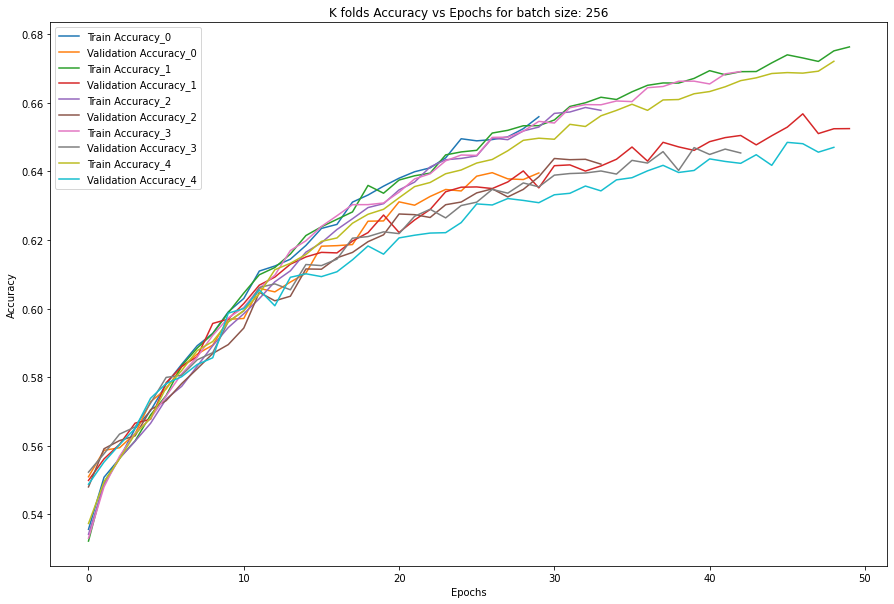

In [25]:
plt_1 = plt.figure(figsize=(15, 10))
optimal_batch_model = str(table_df.loc[optimal_batch_size, "Batch model"])
fold = 0

Q2_legend_list = []

while(fold<no_folds):
    plt.plot(Q2_history[optimal_batch_model + model_fold[fold]].history["accuracy"])
    Q2_legend_list.append("Train Accuracy" + model_fold[fold])
    plt.plot(Q2_history[optimal_batch_model + model_fold[fold]].history["val_accuracy"])
    Q2_legend_list.append("Validation Accuracy" + model_fold[fold])
    fold+=1

plt.legend(Q2_legend_list)
plt.title('K folds Accuracy vs Epochs for batch size: ' + str(optimal_batch_size))
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

In [26]:
Q2E_model = Sequential([Dense(num_neurons, activation='relu'),
                Dropout(0.2), Dense(num_neurons, activation ='relu'),
                Dropout(0.2), Dense(num_neurons, activation='relu'),
                Dropout(0.2), Dense(1, activation='sigmoid')])

Q2E_model.compile(optimizer='adam', 
            loss='binary_crossentropy',
            metrics=['accuracy'])

Q2E_history = {}
Q2E_history["Q2E_model"] = Q2E_model.fit(X_train_scaled, y_train,
                batch_size = optimal_batch_size,
                epochs=no_epochs,
                verbose=1,
                use_multiprocessing=True,
                validation_data=(X_test_scaled, y_test), callbacks=[callback, cb])




Epoch 1/100
499/499 [==============================] - 3s 4ms/step - loss: 0.6900 - accuracy: 0.5344 - val_loss: 0.6853 - val_accuracy: 0.5492
Epoch 2/100
499/499 [==============================] - 2s 4ms/step - loss: 0.6834 - accuracy: 0.5532 - val_loss: 0.6817 - val_accuracy: 0.5575
Epoch 3/100
499/499 [==============================] - 2s 4ms/step - loss: 0.6805 - accuracy: 0.5581 - val_loss: 0.6806 - val_accuracy: 0.5582
Epoch 4/100
499/499 [==============================] - 2s 4ms/step - loss: 0.6779 - accuracy: 0.5637 - val_loss: 0.6769 - val_accuracy: 0.5645
Epoch 5/100
499/499 [==============================] - 2s 4ms/step - loss: 0.6750 - accuracy: 0.5691 - val_loss: 0.6743 - val_accuracy: 0.5753
Epoch 6/100
499/499 [==============================] - 2s 4ms/step - loss: 0.6703 - accuracy: 0.5789 - val_loss: 0.6719 - val_accuracy: 0.5792
Epoch 7/100
499/499 [==============================] - 2s 4ms/step - loss: 0.6680 - accuracy: 0.5835 - val_loss: 0.6685 - val_accuracy: 0.5871

#### Line Plot of Accuracy vs Epochs for optimal batch size 

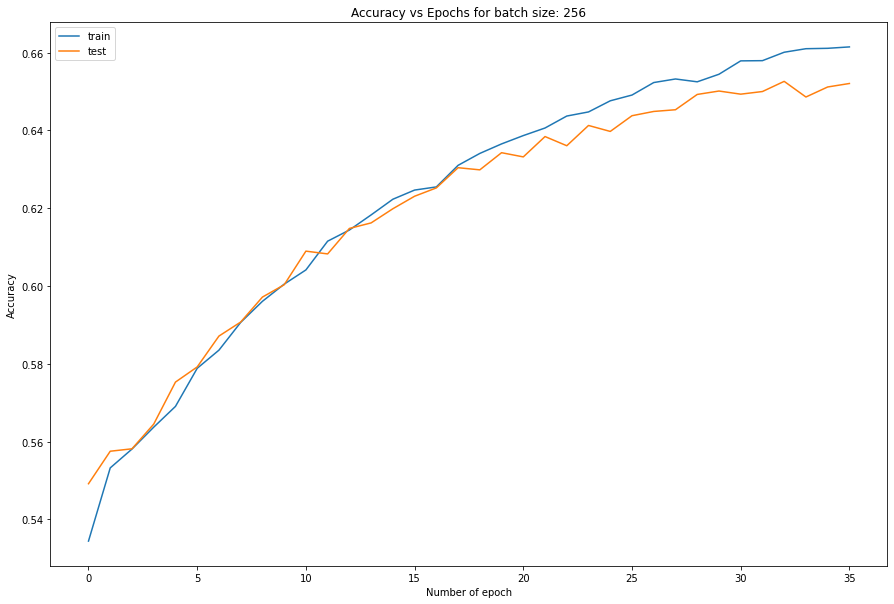

In [27]:
plt_1 = plt.figure(figsize=(15, 10))
plt.plot(Q2E_history['Q2E_model'].history['accuracy'])
plt.plot(Q2E_history['Q2E_model'].history['val_accuracy'])
plt.title('Accuracy vs Epochs for batch size: ' + str(optimal_batch_size))
plt.ylabel('Accuracy')
plt.xlabel('Number of epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## QUESTION 3

In [28]:
model_neurons_list = ["model_neurons_64", "model_neurons_128", "model_neurons_256"]
num_neurons_list = [64,128,256]

Q3_X, Q3_Y = X_train_scaled, y_train
neurons_idx = 0

#### Find the optimal number of hidden neurons for the first hidden layer

In [29]:
Q3_cb = TimingCallback()
Q3_time_taken_dict = {}
Q3_model_acc = {}
Q3_model_train_acc = {}
Q3_model_loss = {}
Q3_history = {}
for model_neurons in model_neurons_list:    
    fold = 0
    val_acc = []
    train_acc = []
    val_loss = []
    time_taken_list = []
    for train_idx, test_idx in cv.split(Q3_X, Q3_Y):
        Q3_cb = TimingCallback()
        Q3_X_train, Q3_y_train  = Q3_X[train_idx], Q3_Y[train_idx]
        Q3_X_test, Q3_y_test = Q3_X[test_idx], Q3_Y[test_idx]
        Q3_model = Sequential([Dense(num_neurons_list[neurons_idx], activation='relu'),
                        Dropout(0.2), Dense(128, activation ='relu'),
                        Dropout(0.2), Dense(128, activation='relu'),
                        Dropout(0.2), Dense(1, activation='sigmoid')])
        
        Q3_model.compile(optimizer='adam', 
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
        
        Q3_history[model_neurons + model_fold[fold]] = Q3_model.fit(Q3_X_train, Q3_y_train,
                        batch_size = optimal_batch_size,
                        epochs=no_epochs,
                        verbose=1,
                        use_multiprocessing=True,
                        validation_data=(Q3_X_test, Q3_y_test), callbacks=[callback, Q3_cb])
        
        #Time taken of final epoch for each fold 
        time_taken_list.append(Q3_cb.times[-1])
        #print("Time Taken for final epoch " + model_neurons + model_fold[fold] + ": {}".format(Q3_cb.times[-1]))

        #Val accuracy of final epoch of each fold
        val_acc.append(Q3_history[model_neurons + model_fold[fold]].history['val_accuracy'][-1])

        #Train accuracy of final epoch of each fold
        train_acc.append(Q3_history[model_neurons + model_fold[fold]].history['accuracy'][-1])

        #Val loss of final epoch of each fold
        val_loss.append(Q3_history[model_neurons + model_fold[fold]].history['val_loss'][-1])
        
        #print(model_neurons +' fold %d test accuracy %g'%(fold, val_acc[fold]))
        fold += 1
    
    Q3_model_acc[model_neurons] = val_acc
    Q3_model_train_acc[model_neurons] = train_acc
    Q3_time_taken_dict[model_neurons]= time_taken_list
    Q3_model_loss[model_neurons] = val_loss
    print(model_neurons + '* mean accuracy = %g *'% np.mean(val_acc))
    neurons_idx+=1

Epoch 1/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6919 - accuracy: 0.5299 - val_loss: 0.6859 - val_accuracy: 0.5463
Epoch 2/100
399/399 [==============================] - 1s 3ms/step - loss: 0.6860 - accuracy: 0.5462 - val_loss: 0.6833 - val_accuracy: 0.5521
Epoch 3/100
399/399 [==============================] - 1s 3ms/step - loss: 0.6836 - accuracy: 0.5516 - val_loss: 0.6810 - val_accuracy: 0.5602
Epoch 4/100
399/399 [==============================] - 1s 3ms/step - loss: 0.6815 - accuracy: 0.5569 - val_loss: 0.6801 - val_accuracy: 0.5624
Epoch 5/100
399/399 [==============================] - 1s 3ms/step - loss: 0.6798 - accuracy: 0.5616 - val_loss: 0.6774 - val_accuracy: 0.5668
Epoch 6/100
399/399 [==============================] - 1s 3ms/step - loss: 0.6779 - accuracy: 0.5637 - val_loss: 0.6767 - val_accuracy: 0.5728
Epoch 7/100
399/399 [==============================] - 1s 3ms/step - loss: 0.6754 - accuracy: 0.5707 - val_loss: 0.6745 - val_accuracy: 0.5759

## Question 3A


#### Mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons

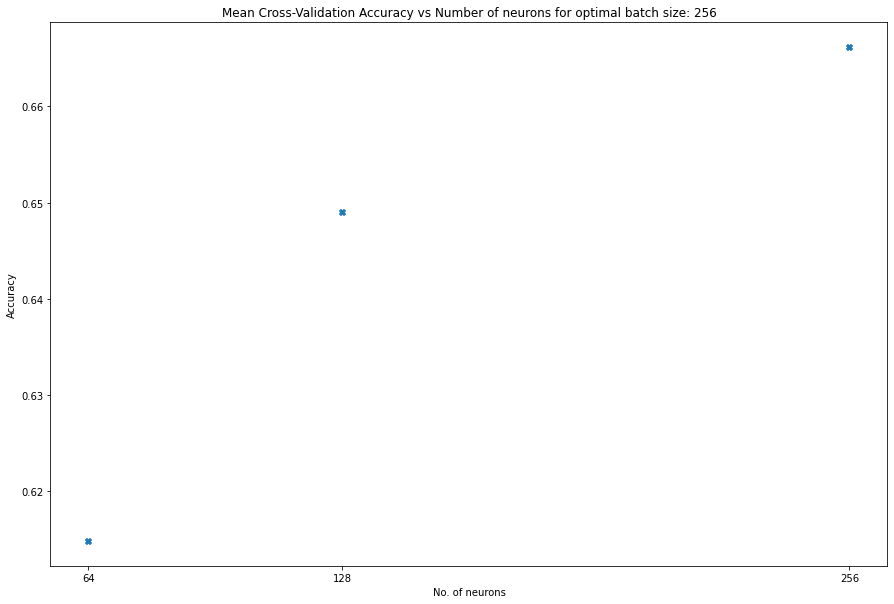

In [30]:
Q3_mean_val_acc = []
for key, value in Q3_model_acc.items():
    Q3_mean_val_acc.append(np.mean(value))

Q3_mean_val_loss = []
for key, value in Q3_model_loss.items():
    Q3_mean_val_loss.append(np.mean(value))

plt_1 = plt.figure(figsize=(15, 10))
plt.scatter(num_neurons_list, Q3_mean_val_acc, marker = 'X')
plt.title('Mean Cross-Validation Accuracy vs Number of neurons for optimal batch size: {}'.format(optimal_batch_size))
plt.ylabel('Accuracy')
plt.xlabel('No. of neurons')
plt.xticks(num_neurons_list)
plt.show()

In [31]:
Q3_mean_time_taken = []
for key, value in Q3_time_taken_dict.items():
    Q3_mean_time_taken.append(np.mean(value))

#### Mean Time Taken on the final epoch for different numbers of hidden-layer neurons

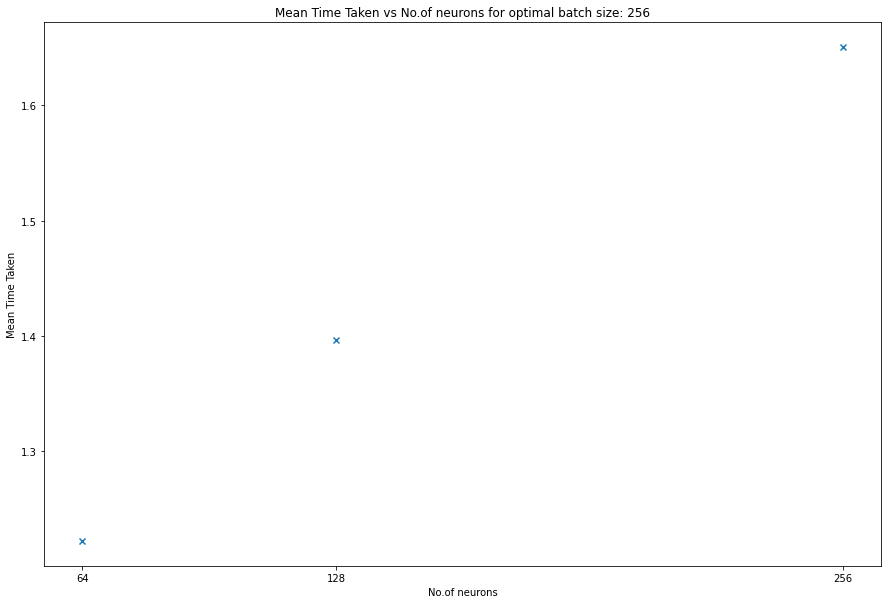

In [32]:
plt_1 = plt.figure(figsize=(15, 10))
plt.scatter(num_neurons_list, Q3_mean_time_taken, marker = 'x')  
plt.title('Mean Time Taken vs No.of neurons for optimal batch size: {}'.format(optimal_batch_size))
plt.ylabel('Mean Time Taken')
plt.xlabel('No.of neurons')
plt.xticks(num_neurons_list)
plt.show()

## Question 3B 
#### Select the optimal number of neurons for the hidden layer

In [33]:
Q3_table_df = pd.DataFrame.from_dict(Q3_model_acc,orient='index', columns=["fold_0", "fold_1", "fold_2", "fold_3", "fold_4"])
Q3_table_df["mean_val_acc"] = Q3_mean_val_acc
Q3_table_df["mean_val_loss"] = Q3_mean_val_loss
Q3_table_df["mean_time_taken"] = Q3_mean_time_taken
Q3_table_df["No. of neurons"] = num_neurons_list
Q3_table_df["Model Neuron List"] = model_neurons_list
Q3_table_df.set_index('No. of neurons', inplace = True)
Q3_table_df.head()

,fold_0,fold_1,fold_2,fold_3,fold_4,mean_val_acc,mean_val_loss,mean_time_taken,Model Neuron List
No. of neurons,,,,,,,,,
64,0.616946,0.607697,0.620419,0.606937,0.622026,0.614805,0.647060,1.221972,model_neurons_64
128,0.644027,0.640814,0.652949,0.655497,0.652048,0.649067,0.615343,1.396663,model_neurons_128
256,0.672676,0.667699,0.669175,0.648324,0.673094,0.666194,0.596277,1.650618,model_neurons_256


In [34]:
optimal_no_neurons = int(Q3_table_df['mean_val_acc'].idxmax())

data = {"Optimal Batch": [optimal_batch_size], "Optimal No.of neurons": [optimal_no_neurons] }

data_df = pd.DataFrame.from_dict(data)
data_df

,Optimal Batch,Optimal No.of neurons
0,256,256


**The selected optimal number of neurons in the hidden layer is 256. The rationale is that it yields the highest mean validation accuracy. It is possible that with the increase in number of neurons in the hidden layer, it allows the train model to be more adaptive and higher capacity to learn.**

**In terms of time taken, when there is a increase number of neurons and the mean time taken for the final epoch decreases significantly thus reinforcing the idea that the optimal number of neurons is 256**


## Question 3C 


#### Train & Test accuracies against training epochs with the optimal number of neurons for different folds

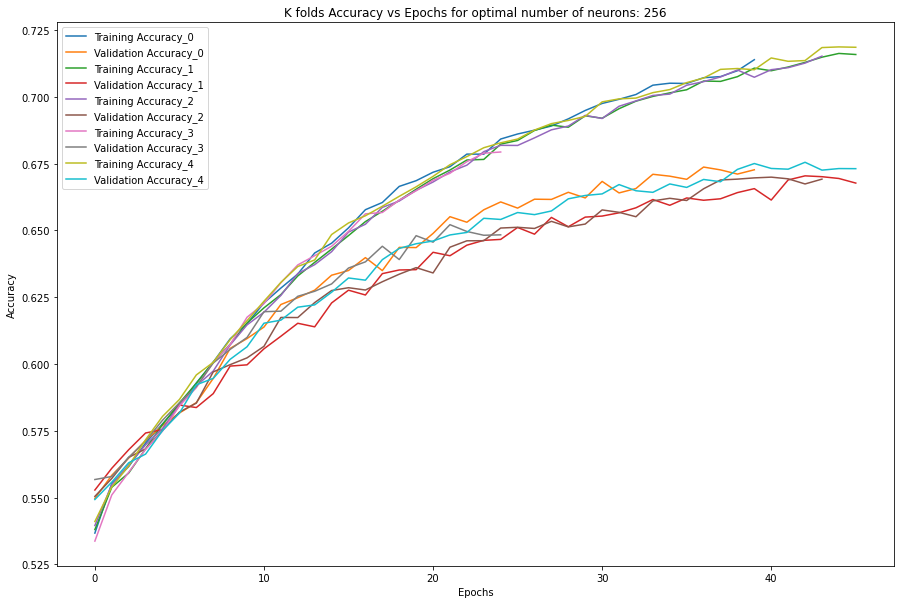

In [35]:
plt_1 = plt.figure(figsize=(15, 10))
fold = 0
optimal_neuron_model = str(Q3_table_df.loc[optimal_no_neurons, "Model Neuron List"])

Q3_legend_list = []

while(fold<no_folds):

    plt.plot(Q3_history[optimal_neuron_model + model_fold[fold]].history["accuracy"])
    Q3_legend_list.append("Training Accuracy" + model_fold[fold])

    plt.plot(Q3_history[optimal_neuron_model + model_fold[fold]].history["val_accuracy"])
    Q3_legend_list.append("Validation Accuracy" + model_fold[fold])
    fold+=1

plt.legend(Q3_legend_list)
plt.title('K folds Accuracy vs Epochs for optimal number of neurons: ' + str(optimal_no_neurons))
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

In [36]:
Q3C_model = Sequential([Dense(optimal_no_neurons, activation='relu'),
                Dropout(0.2), Dense(128, activation ='relu'),
                Dropout(0.2), Dense(128, activation='relu'),
                Dropout(0.2), Dense(1, activation='sigmoid')])

Q3C_model.compile(optimizer='adam', 
            loss='binary_crossentropy',
            metrics=['accuracy'])

Q3C_history = {}
Q3C_history["Q3C_model"] = Q3C_model.fit(X_train_scaled, y_train,
                batch_size = optimal_batch_size,
                epochs=no_epochs,
                verbose=1,
                use_multiprocessing=True,
                validation_data=(X_test_scaled, y_test), callbacks=[callback, cb])


Epoch 1/100
499/499 [==============================] - 3s 5ms/step - loss: 0.6889 - accuracy: 0.5405 - val_loss: 0.6835 - val_accuracy: 0.5518
Epoch 2/100
499/499 [==============================] - 2s 5ms/step - loss: 0.6826 - accuracy: 0.5557 - val_loss: 0.6806 - val_accuracy: 0.5562
Epoch 3/100
499/499 [==============================] - 2s 5ms/step - loss: 0.6787 - accuracy: 0.5639 - val_loss: 0.6777 - val_accuracy: 0.5666
Epoch 4/100
499/499 [==============================] - 2s 5ms/step - loss: 0.6752 - accuracy: 0.5707 - val_loss: 0.6740 - val_accuracy: 0.5714
Epoch 5/100
499/499 [==============================] - 2s 4ms/step - loss: 0.6713 - accuracy: 0.5763 - val_loss: 0.6715 - val_accuracy: 0.5814
Epoch 6/100
499/499 [==============================] - 2s 4ms/step - loss: 0.6655 - accuracy: 0.5879 - val_loss: 0.6665 - val_accuracy: 0.5831
Epoch 7/100
499/499 [==============================] - 2s 5ms/step - loss: 0.6595 - accuracy: 0.5969 - val_loss: 0.6612 - val_accuracy: 0.5958

#### Train & Test accuracy against training epochs with the optimal number of neurons 

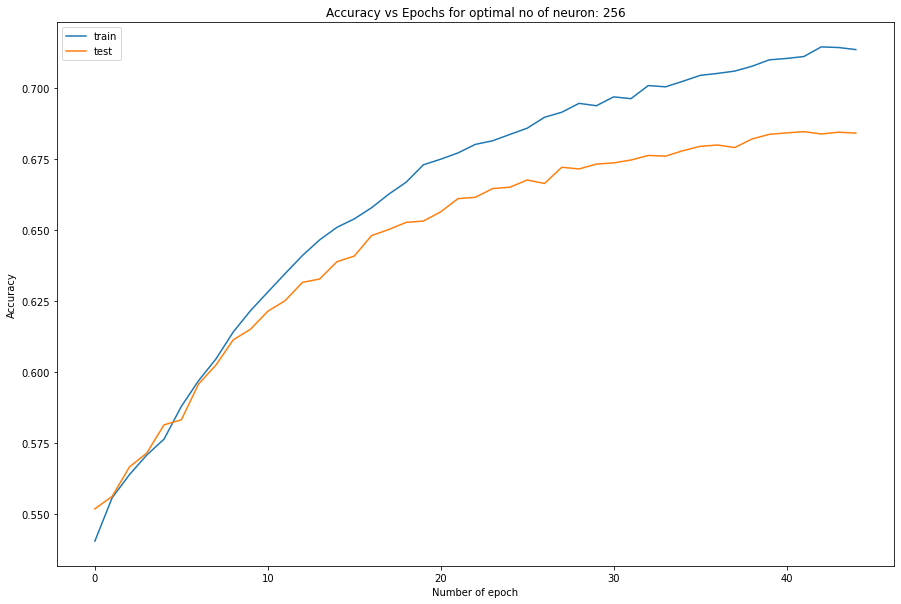

In [37]:
plt_1 = plt.figure(figsize=(15, 10))
plt.plot(Q3C_history['Q3C_model'].history['accuracy'])
plt.plot(Q3C_history['Q3C_model'].history['val_accuracy'])
plt.title('Accuracy vs Epochs for optimal no of neuron: ' + str(optimal_no_neurons))
plt.ylabel('Accuracy')
plt.xlabel('Number of epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Question 3D 
#### How does dropout works, and what is the purpose of dropouts?

**Dropout is a technique where randomly selected neurons are ignored during training to avoid overfitting. The neurons are presented with a probability p and presented to the next layer with weight W to the next layer at the training time. At test time, the weights are always present and presented to the network with weights multipled by probability p (dropout rate = 0.2). The output at the test time is same as the expected output at the training time**


**Dropout prevents all neurons in a layer from syncrhonously optimizing their weights. It prevents all the neurons from  converging to the same goal, thus decorrelating the weights. As such, it removes the simple dependencies between the neurons and increases the robustness of the model.**



## Question 3E 
#### Besides early stopping and dropout, what is another approach that you could take to address overfitting in the model, and how does it work? Implement the approach

**Weight regularization. Weight regularization ensures that the weights of the network as large network weights indicates that the model is overfitting. The learning algorithm would encourage the network towards using small weights by penalizing the model with a larger loss score.**

**Through experimenting with the values, L2 = 0.000001 yields a higher val accuracy score**

**I have used the model with the implementation of weight regularizations for the entirety of Question 4**


In [38]:
# Implementation of weight regularization with optimal batch and number of neurons
from tensorflow.keras import regularizers

optimized_model = Sequential([Dense(optimal_no_neurons, activation='relu', kernel_regularizer =regularizers.L2(0.000001)),
                        Dropout(0.2), Dense(128, activation ='relu', kernel_regularizer =regularizers.L2(0.000001)),
                        Dropout(0.2), Dense(128, activation='relu', kernel_regularizer =regularizers.L2(0.000001)),
                        Dropout(0.2), Dense(1, activation='sigmoid')])

# Default values for l1 and l2 are 0.01

optimized_model.compile(optimizer='adam', 
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

## Question 4

In [39]:
Q4_history = {}
Q4_history['optimized_model'] = optimized_model.fit(X_train_scaled, y_train,
                            epochs = no_epochs, verbose = 1,
                            batch_size = optimal_batch_size, validation_data = (X_test_scaled, y_test), callbacks = [callback])

Epoch 1/100
499/499 [==============================] - 3s 5ms/step - loss: 0.6897 - accuracy: 0.5391 - val_loss: 0.6842 - val_accuracy: 0.5540
Epoch 2/100
499/499 [==============================] - 2s 4ms/step - loss: 0.6829 - accuracy: 0.5533 - val_loss: 0.6807 - val_accuracy: 0.5611
Epoch 3/100
499/499 [==============================] - 2s 4ms/step - loss: 0.6792 - accuracy: 0.5632 - val_loss: 0.6786 - val_accuracy: 0.5646
Epoch 4/100
499/499 [==============================] - 2s 4ms/step - loss: 0.6748 - accuracy: 0.5720 - val_loss: 0.6735 - val_accuracy: 0.5744
Epoch 5/100
499/499 [==============================] - 2s 4ms/step - loss: 0.6707 - accuracy: 0.5775 - val_loss: 0.6707 - val_accuracy: 0.5811
Epoch 6/100
499/499 [==============================] - 2s 4ms/step - loss: 0.6647 - accuracy: 0.5894 - val_loss: 0.6634 - val_accuracy: 0.5921
Epoch 7/100
499/499 [==============================] - 2s 4ms/step - loss: 0.6591 - accuracy: 0.5984 - val_loss: 0.6585 - val_accuracy: 0.5996

In [40]:
optimized_model.save('optimized_model/')

INFO:tensorflow:Assets written to: optimized_model/assets


#### Plot of optimized model train test accuracies against epochs

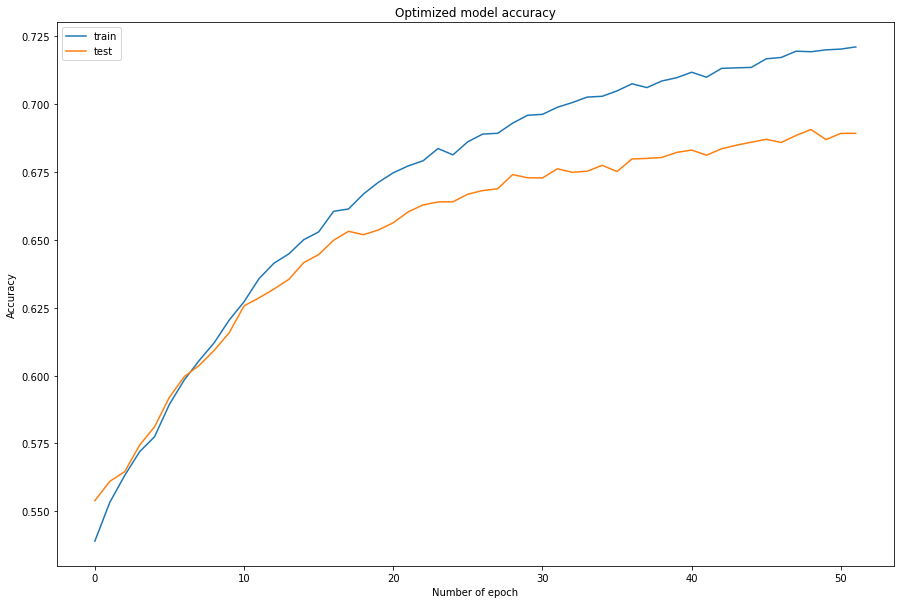

In [41]:
plt_1 = plt.figure(figsize=(15, 10))
plt.plot(Q4_history['optimized_model'].history['accuracy'])
plt.plot(Q4_history['optimized_model'].history['val_accuracy'])
plt.title('Optimized model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Question 4A

In [42]:

neg_voice_record_df = pd.read_csv('Q4_neg_voice_record.csv')
pos_voice_record_df = pd.read_csv('Q4_pos_voice_record.csv')
threshold = 0.5


In [43]:
neg_voice_record_df = neg_voice_record_df.drop(["filename"],axis = 1)
pos_voice_record_df = pos_voice_record_df.drop(["filename"], axis=1)



In [44]:
def process_dataset(df_train, df_test):
    
  standard_scaler = preprocessing.StandardScaler()
  df_train_scaled = standard_scaler.fit_transform(df_train)

  df_test_scaled = standard_scaler.transform(df_test)

  return df_test_scaled


neg_voice_record_df_scaled = process_dataset(X_train, neg_voice_record_df)
pos_voice_record_df_scaled = process_dataset(X_train, pos_voice_record_df)

## Question 4B 
**Do a model prediction on your sample test dataset with threshold = 0.5**

In [45]:
neg_result_label = (optimized_model.predict(neg_voice_record_df_scaled)>threshold).astype("int32")
pos_result_label = (optimized_model.predict(pos_voice_record_df_scaled)>threshold).astype("int32")

data = {"Label": ["Negative Voice ", "Positive Voice"],"Result":[neg_result_label, pos_result_label]}


data_df = pd.DataFrame.from_dict(data)
data_df

1/1 [==============================] - 0s 14ms/step


,Label,Result
0,Negative Voice,[[0]]
1,Positive Voice,[[1]]


## Question 4C
#### Identify most important features using SHAP

In [46]:
tf.compat.v1.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()

Instructions for updating:
non-resource variables are not supported in the long term


In [47]:
X_train_sample = X_train_scaled[np.random.choice(len(X_train_scaled), 1000, replace=False)]
X_test_sample = X_test_scaled[np.random.choice(len(X_test_scaled), 1000, replace=False)]

In [48]:
model = keras.models.load_model('optimized_model/')
explainer = shap.DeepExplainer(model , X_train_sample)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


#### Force plot of neg voice record

In [49]:
shap_values = explainer.shap_values(neg_voice_record_df_scaled)
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features = X_test.columns)

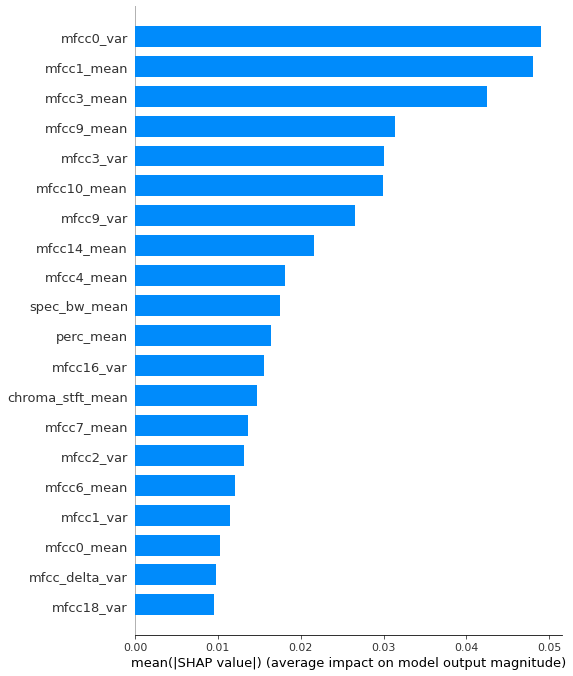

In [50]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = X_test.columns)

#### Force plot of pos voice record

In [51]:
shap_values = explainer.shap_values(pos_voice_record_df_scaled)
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features = X_test.columns)

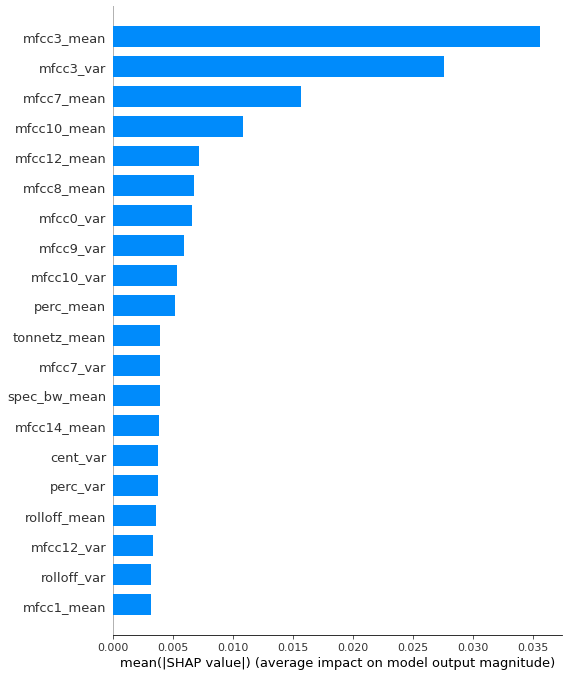

In [52]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = X_test.columns)

#### Observation

**From the force plot of both the pos and neg_voice record, it shows the top most influential features that led to prediction value indicated. The red color features influence positivity(towards the predicted value) and the blue color influence negativity(away from the predicted value). With the force plot and summary, we can identify the magnitude of the features' impact to the resulting predicted value,**

#### Analysis on Positive Voice Record

**In the positive voice recording, we can identify that the features in red(mfcc3_mean, mfcc10_mean, mfcc0_var, mfcc10_var, perc_mean) to be the most influential features in influencing the prediction to be closer to 1 (positive label) and in blue(mfcc3_var, mfcc7_mean, mfcc12_mean, mfcc8_mean, mfcc9_var) are the most influential features in influencing the predict to be closer to 0 (negative label)**

**From the summary plot, we can then identify the magnitude of the the features' impact to the resulting predicted value**



## Discussion Points

#### 1. Limitations of FFN

**FFN is prone to overfitting and with given large number of parameters, the model will be more complex and could take a long time to train. In addition, due to the risk of overfitting, the model may lose the ability to generalize to new examples.**

**Also, feed-forward neural networks may have results that are difficult to interpret due to the complexitiy of the model's architecture.**


#### 2. Most impactful parameter

**In terms of time taken for every epoch，the batch size is the most impactful parameter as from the table at Q2b, we notice that doubling the batch size shorterns the time taken for the final epoch nearly by half.**

**In terms of accuracy, the number of neurons in the first hidden layer is the most impactful paramater as from the table at Q3b, we notice that there is significant rise in accuracy when the number of neurons increases**

#### 3. Alternative approaches

**We can use CNN model architecture for genre classfication as well. Similar to the assignment, we have to perform feature extraction and define the model architecture**

#### 4. Other dataset

**Analysing the audio waveforms to idenitify the species of the subject(animals). Perhaps more hidden layer is required for the model to learn the relationship between the features extracted from the audio of different species** 

**Also, we can do speech enhancement. To improve the quality of the audio, we would need a very large and complex and neural network model which would need an increase in hidden layers and number of units.**


#### 5. Neural Network Ensemble

**An ensemble of neural network can be done to achieve diversification in order to build models that can generalize better**

